In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

In [ ]:
X_train = []
Y_train = []
image_size = 150
labels = ['glioma','meningioma','notumor','pituitary']
for i in labels:
  folderPath = os.path.join('/content/drive/MyDrive/final project/Training',i)
  for j in os.listdir(folderPath):
    img_path = os.path.join(folderPath, j)
    img = cv2.imread(img_path)
    img = cv2.resize(img,(image_size,image_size))
    X_train.append(img)
    Y_train.append(i)

for i in labels:
  folderPath = os.path.join('/content/drive/MyDrive/final project/Testing',i)
  for j in os.listdir(folderPath):
    img_path = os.path.join(folderPath, j)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (image_size, image_size))
    X_train.append(img)
    Y_train.append(i)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,Y_train,test_size=0.3,random_state=101)

In [ ]:
# Convert the labels to categorical format
y_train_new = []
for i in y_train:
    if i == 'glioma':
        y_train_new.append(0)
    elif i == 'meningioma':
        y_train_new.append(1)
    elif i == 'notumor':
        y_train_new.append(2)
    elif i == 'pituitary':
        y_train_new.append(3)
if len(y_train_new) > 0:
    y_train = tf.keras.utils.to_categorical(y_train_new)

y_test_new = []
for i in y_test:
    if i == 'glioma':
        y_test_new.append(0)
    elif i == 'meningioma':
        y_test_new.append(1)
    elif i == 'notumor':
        y_test_new.append(2)
    elif i == 'pituitary':
        y_test_new.append(3)
if len(y_test_new) > 0:
    y_test = tf.keras.utils.to_categorical(y_test_new)


In [ ]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   brightness_range=[0.2, 1.2],
                                   channel_shift_range=0.2,
                                   rescale=1./255,
                                   fill_mode='nearest')
train_datagen.fit(X_train)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = InceptionV3(include_top=False, input_shape=(image_size, image_size, 3))
x = GlobalAveragePooling2D()(model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
preds = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=preds)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.00001),  # Smaller learning rate
              metrics=['acc'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


history = model.fit(X_train, y_train,
                    epochs=25,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/25
39/39 [==============================] - 58s 462ms/step - loss: 2.9627 - acc: 0.2478 - val_loss: 2.8010 - val_acc: 0.2850
Epoch 2/25
39/39 [==============================] - 17s 424ms/step - loss: 2.8119 - acc: 0.3167 - val_loss: 2.6776 - val_acc: 0.4495
Epoch 3/25
39/39 [==============================] - 17s 436ms/step - loss: 2.7283 - acc: 0.3761 - val_loss: 2.5801 - val_acc: 0.5789
Epoch 4/25
39/39 [==============================] - 17s 429ms/step - loss: 2.6345 - acc: 0.4462 - val_loss: 2.4897 - val_acc: 0.6728
Epoch 5/25
39/39 [==============================] - 16s 405ms/step - loss: 2.5328 - acc: 0.5123 - val_loss: 2.3856 - val_acc: 0.7326
Epoch 6/25
39/39 [==============================] - 17s 434ms/step - loss: 2.4450 - acc: 0.5759 - val_loss: 2.2859 - val_acc: 0.7681
Epoch 7/25
39/39 [==============================] - 17s 437ms/step - loss: 2.3421 - acc: 0.6507 - val_loss: 2.1839 - val_acc: 0.7999
Epoch 8/25
39/39 [==============================] - 16s 412ms/step - 

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

66/66 [==============================] - 2s 31ms/step - loss: 1.5457 - acc: 0.9469
Test accuracy: 0.9468942880630493


In [ ]:
model.save('/content/drive/MyDrive/BrainTumor.h5')

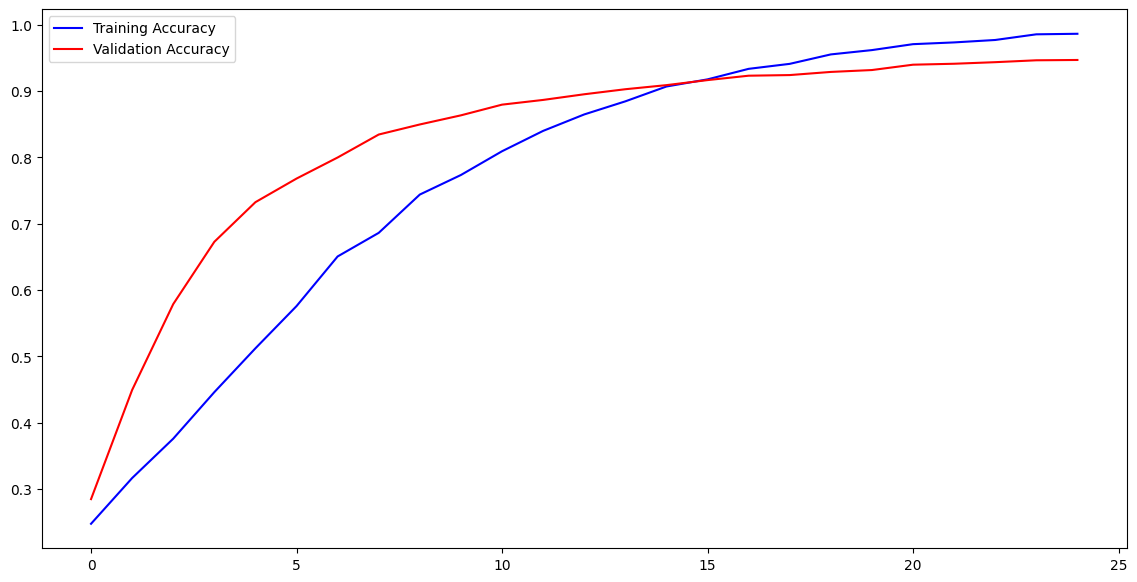

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(len(acc))
fig = plt.figure(figsize=(14, 7))
plt.plot(epochs, acc, 'b', label="Training Accuracy")  # Set color of training accuracy to blue
plt.plot(epochs, val_acc, 'r', label="Validation Accuracy")  # Set color of validation accuracy to red
plt.legend(loc='upper left')
plt.show()


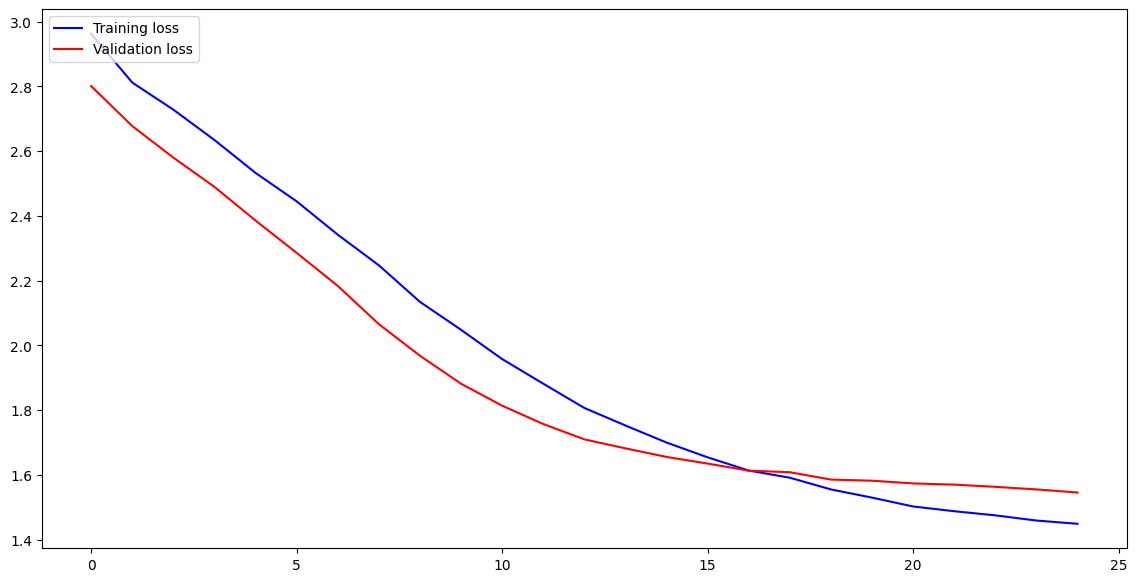

In [ ]:
loss= history.history['loss']
val_loss= history.history['val_loss']
epochs= range(len(loss))
fig =plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'b', label="Training loss")
plt.plot(epochs, val_loss,'r',label= "Validation loss")
plt.legend(loc='upper left')
plt.show()

In [ ]:
img = cv2.imread('/content/drive/MyDrive/final project/Testing/pituitary/Te-pi_0146.jpg')
img = cv2.resize(img,(150,150))
img_array = np.array(img)
img_array.shape

(150, 150, 3)

In [ ]:
img_array = img_array.reshape(1,150,150,3)
img_array.shape

(1, 150, 150, 3)

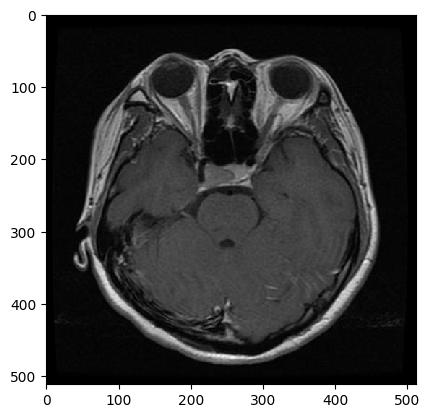

In [ ]:
from tensorflow.keras.preprocessing import image
img = image.load_img('/content/drive/MyDrive/final project/Testing/pituitary/Te-pi_0146.jpg')
plt.imshow(img,interpolation='nearest')
plt.show()

In [ ]:
a = model.predict(img_array)
indices = a.argmax()
indices

1/1 [==============================] - 3s 3s/step


3

66/66 [==============================] - 2s 31ms/step


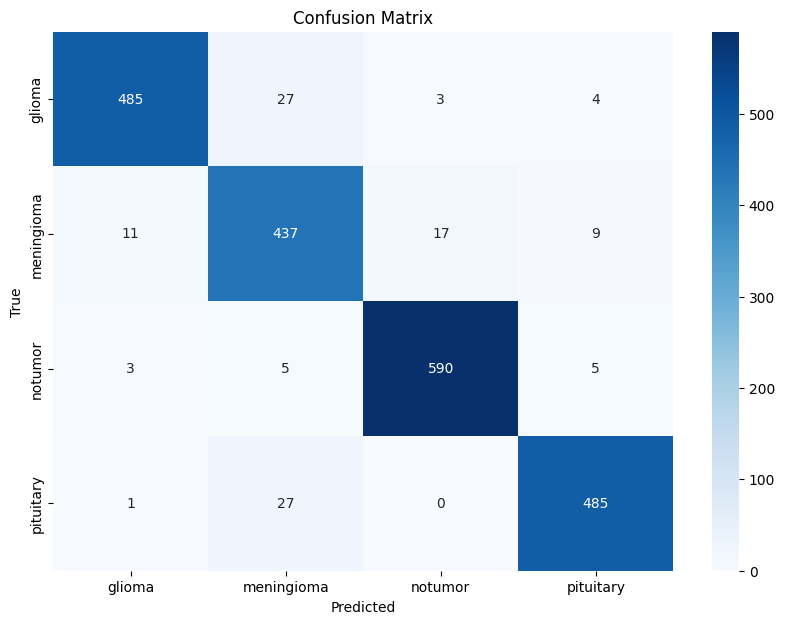

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predicted labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the predicted labels to their corresponding class names
y_test_classes = np.argmax(y_test, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_classes, y_pred_classes, target_names=labels))


              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       519
  meningioma       0.88      0.92      0.90       474
     notumor       0.97      0.98      0.97       603
   pituitary       0.96      0.95      0.95       513

    accuracy                           0.95      2109
   macro avg       0.95      0.95      0.95      2109
weighted avg       0.95      0.95      0.95      2109



1/1 [==============================] - 3s 3s/step


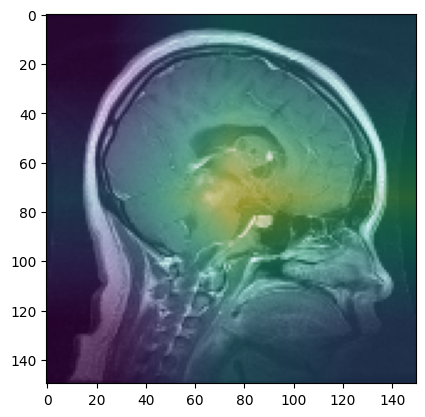

In [ ]:
#!pip install tf-explain

from tf_explain.core.grad_cam import GradCAM
import matplotlib.pyplot as plt

# Load the model
model = load_model('/content/drive/MyDrive/BrainTumor.h5')

# Choose a random image from the test set
img_idx = np.random.randint(0, len(X_test))
img = X_test[img_idx]

# Create a GradCAM explainer
explainer = GradCAM()

# Get the predicted class index
class_idx = np.argmax(model.predict(img[np.newaxis, ...]))

# Compute the heatmap
heatmap = explainer.explain((img[np.newaxis, ...], None), model, class_idx)

# Plot the heatmap and the original image
plt.imshow(img)
plt.imshow(heatmap, alpha=0.5, cmap='jet')
plt.show()
